# X to Autosome Ratio

Here I perform a preliminary dosage compensation experiment in testis. This is a very rough preliminary analysis, but I have played with lots of different normalizations and ways of looking at things and the results are consistent. There appears to be attenuated dosage compensation in germ cells. 

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# The usual suspects
import os
from pathlib import Path
from itertools import zip_longest
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')
sns.mpl.rc("figure", figsize=(10, 10))

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

%reload_ext rpy2.ipython

last updated: 2017-12-01 
Git hash: be0a0f4e40f554797ae36ff599f59180bf69efa6


In [2]:
%%R -o norm -o clusters
.libPaths("/data/fearjm/miniconda3/envs/larval_gonad/lib/R/library")
library('Seurat')

# Load Testis Robj from pilot analysis
load('../../output/testis_seurat.Robj')

# Pull out normalized data
norm = as.data.frame(as.matrix(testis@data))

# Pull out cluster identities
clusters = as.data.frame(testis@ident)
colnames(clusters) = c('cluster')

In [3]:
if isinstance(clusters, pd.DataFrame):
    clusters = clusters['cluster'].convert_objects(convert_numeric=True)
    norm = norm[clusters.index].copy()

In [2]:
# functions
def grouper(iterable, n):
    args = [iter(iterable)] * n
    return zip_longest(*args)

In [44]:
# Constants
REF = os.environ['REFERENCES_DIR']
CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']
BRIAN = ['dj', 'ocn', 'CG10920', 'boil', 'CG1314']  # CG12681 is not called boil
SHAR_PRIMARY = ['CG11635', 'CG18449', 'CG2127', 'CG3927']
SHAR_LATE = ['bb8', 'CG10252', 'djl', 'betaTub85D', 'fzo', 
             'Hsp60B', 'Hsp60C', 'Hsp60D', 'Cyt-c-d']
SHAR_POST = ['schuy', 'hale', 'sunz', 'sowi', 'boly', 't-cup', 'c-cup',
             'h-cup', 'm-cup', 'd-cup', 'wa-cup', 'f-cup', 'w-cup', 'orb', 'soti']

In [8]:
# Create fbgn2symbol and symbol2fbgn map
annot = pd.read_csv(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'),
                   sep='\t', index_col=1)

fbgn2symbol = annot['gene_symbol'].to_dict()
symbol2fbgn = {v: k for k, v in fbgn2symbol.items()}

# Create fbgn2chrom
genes = []
with Path(REF, 'dmel/r6-16/gtf/dmel_r6-16.gtf').open() as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

In [9]:
# germ cells vasa postive
germ = norm.loc[:, (norm.loc[symbol2fbgn['vas']] > 0)]

# somatic cells are dsx positive
soma = norm.loc[:, (norm.loc[symbol2fbgn['dsx']] > 0)]

# Make cluster specific datasets
cluster0 = norm.loc[:, clusters == 0]
cluster1 = norm.loc[:, clusters == 1]
cluster2 = norm.loc[:, clusters == 2]
cluster3 = norm.loc[:, clusters == 3]
cluster4 = norm.loc[:, clusters == 4]
cluster5 = norm.loc[:, clusters == 5]
cluster6 = norm.loc[:, clusters == 6]

# Genes expressed in 1/3 of samples.
expressed = (norm > 0).sum(axis=1) > (norm.shape[1] / 3)

In [75]:
df[expressed].median(axis=1)

FBgn0029718    0.000000
FBgn0261014    0.807474
FBgn0260799    0.866651
FBgn0265630    0.000000
FBgn0265998    0.452630
FBgn0035868    0.000000
FBgn0032030    0.000000
FBgn0083167    3.579847
FBgn0043070    1.601865
FBgn0010352    0.000000
FBgn0262740    0.775043
FBgn0030955    0.748093
FBgn0261602    2.262930
FBgn0027556    1.993291
FBgn0032961    0.000000
FBgn0261563    0.619422
FBgn0034232    0.000000
FBgn0032050    0.000000
FBgn0026873    0.000000
FBgn0001316    2.165736
FBgn0033188    0.560883
FBgn0050410    1.751268
FBgn0023172    0.560883
FBgn0263197    0.748093
FBgn0033428    0.000000
FBgn0031971    2.249522
FBgn0013770    2.499805
FBgn0030057    0.763086
FBgn0004363    2.686957
FBgn0054015    0.000000
                 ...   
FBgn0267791    0.560883
FBgn0004636    1.919965
FBgn0031979    0.000000
FBgn0283477    0.576870
FBgn0021825    0.000000
FBgn0086446    0.479948
FBgn0040228    0.000000
FBgn0010622    0.000000
FBgn0263006    0.338126
FBgn0283478    0.000000
FBgn0028341    0

In [ ]:
def center_chrom(chrom, expression, data=None, by='autosome'):
    if data is not None:
        if isinstance(chrom, str):
            chrom = data[chrom]
            
        if isinstance(expression, str):
            expression = data[expression]
    
    if by == 'autosome':
        pass
    else:
        pass
    
    return 

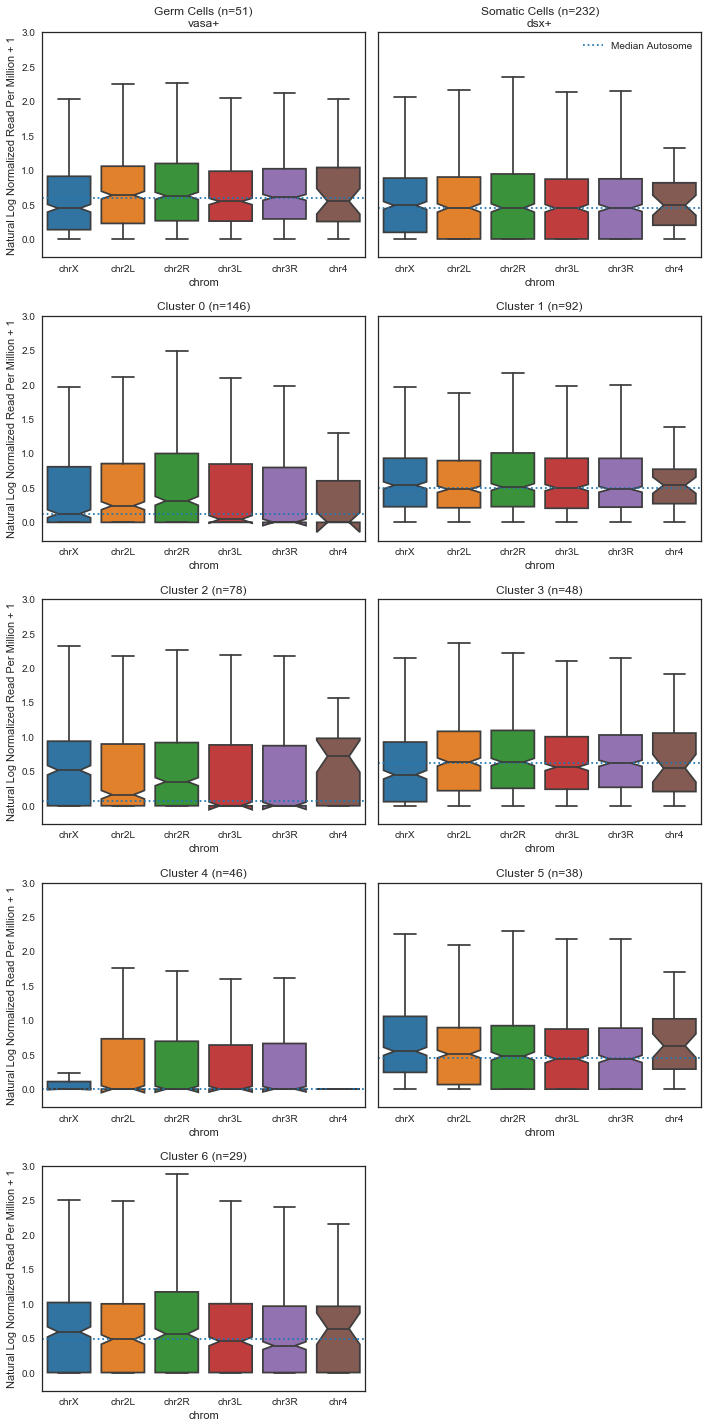

In [71]:
# Chromosome boxplots for different clusters
def plot_xtoa(df, ax, name):
    merged = df[expressed].join(fbgn2chrom).set_index('chrom', append=True)
    sns.boxplot(merged.index.get_level_values(-1), 
                merged.median(axis=1), notch=True, 
                ax=ax, order=CHROMS,  fliersize=0)
    ax.set_title(name)
    ax.set_ylim(None, 3)
    ax.axhline(merged.loc[
        (slice(None), ['chr2L', 'chr2R', 'chr3L', 'chr3R']), :
    ].median(axis=1).median(), ls=':', label='Median Autosome')
    ax.set_ylabel('Natural Log Normalized Read Per Million + 1')

cls = [
    ('Germ Cells (n={})\nvasa+'.format(germ.shape[1]), germ),
    ('Somatic Cells (n={})\ndsx+'.format(soma.shape[1]), soma),
    ('Cluster 0 (n={})'.format(cluster0.shape[1]), cluster0),
    ('Cluster 1 (n={})'.format(cluster1.shape[1]), cluster1),
    ('Cluster 2 (n={})'.format(cluster2.shape[1]), cluster2),
    ('Cluster 3 (n={})'.format(cluster3.shape[1]), cluster3),
    ('Cluster 4 (n={})'.format(cluster4.shape[1]), cluster4),
    ('Cluster 5 (n={})'.format(cluster5.shape[1]), cluster5),
    ('Cluster 6 (n={})'.format(cluster6.shape[1]), cluster6),
]

# Make Boxplots
fig, axes = plt.subplots(5, 2, figsize=plt.figaspect(2)*2, sharey=True)
for (name, df), ax in zip(cls, axes.flatten()):
    plot_xtoa(df, ax, name)

for ax in axes[:, 1]:
    ax.set_ylabel('')
    
axes[0, 1].legend(loc=1)
axes[-1, -1].set_visible(False)
plt.tight_layout()

In [72]:
BRIAN_FBGN = [symbol2fbgn[x] for x in BRIAN]
SHAR_PRIMARY_FBGN = [symbol2fbgn[x] for x in SHAR_PRIMARY]
SHAR_LATE_FBGN = [symbol2fbgn[x] for x in SHAR_LATE]
SHAR_POST_FBGN = [symbol2fbgn[x] for x in SHAR_POST]

In [56]:
def plot_scatter(A, B, A_label=None, B_label=None, highlight=None, annotate=False, title=None):
    _A = A.median(axis=1)
    _B = B.median(axis=1)
    _fbgns = _A.index.intersection(_B.index).tolist()

    _chrx = fbgn2chrom.loc[_fbgns, 'chrom'] == 'chrX'
    _autosome = fbgn2chrom.loc[_fbgns, 'chrom'].isin(CHROMS) & (fbgn2chrom.loc[_fbgns, 'chrom'] != 'chrX')
    
    plt.scatter(_A.loc[_autosome], _B.loc[_autosome], s=3, c='k', label='Autosomes')
    plt.scatter(_A.loc[_chrx], _B.loc[_chrx], s=8, c='r', label='X')
    ax = plt.gca()
    plt.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], c='r', alpha=.4)

    ax.set_xlabel(f'Cluster {A_label}\nLn Normalized Expression')
    ax.set_ylabel(f'Cluster {B_label}\nLn Normalized Expression')
    
    if highlight is None:
        pass
    else:
        _hi = [x for x in highlight if x in _fbgns]
        plt.scatter(_A.loc[_hi], _B.loc[_hi], s=50, marker='^', c='b', label='Highlighted Genes')
    
        if annotate:
            for pt in zip(zip(_A.loc[_hi].values, _B.loc[_hi].values), _hi):
                plt.annotate(fbgn2symbol[pt[1]], pt[0], xytext=(10,0), textcoords='offset points', fontsize=18)

    plt.legend()
    
    if title is not None:
        ax.set_title(title)

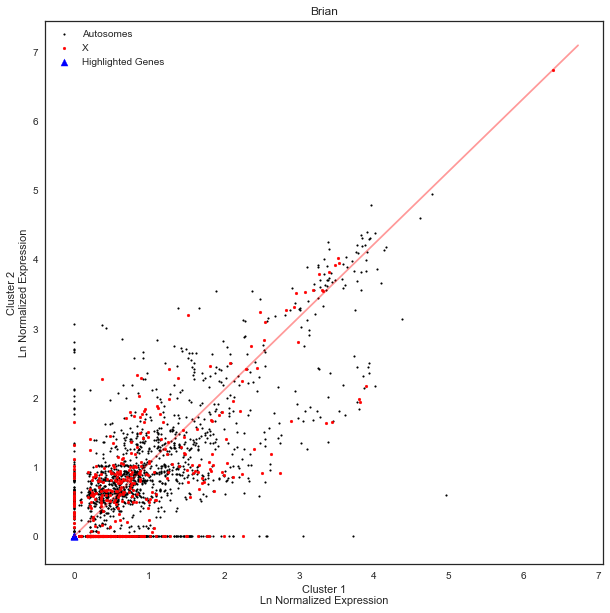

In [57]:
plot_scatter(cluster1, cluster2, 1, 2, BRIAN_FBGN, title='Brian')

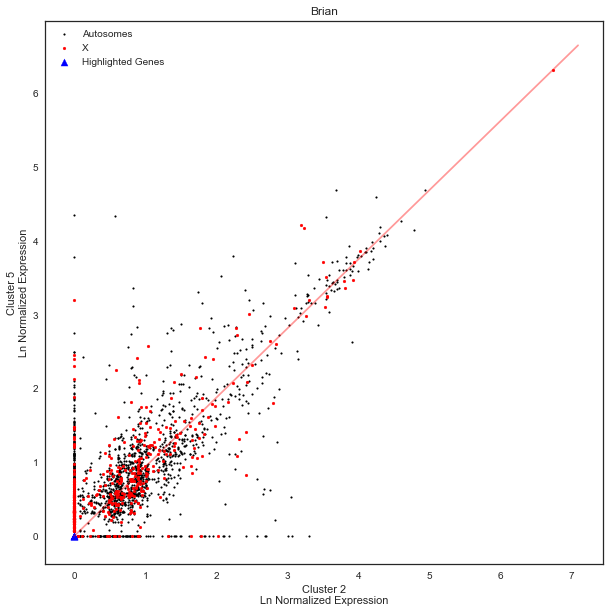

In [67]:
plot_scatter(cluster2, cluster5, 2, 5, BRIAN_FBGN, title='Brian')

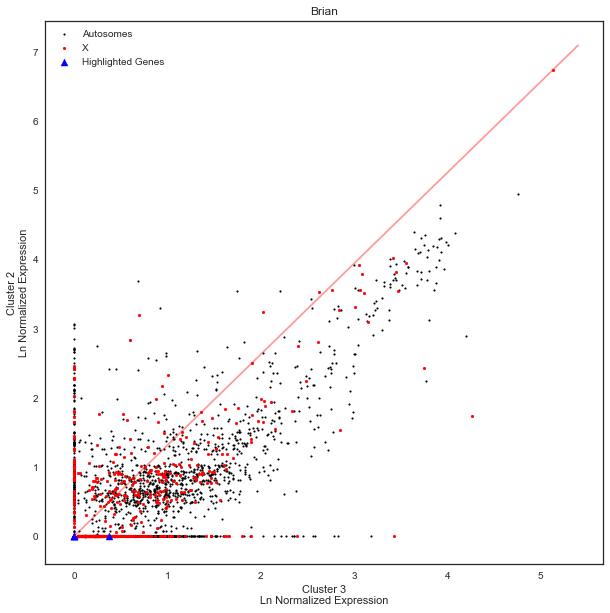

In [59]:
plot_scatter(cluster3, cluster2, 3, 2, BRIAN_FBGN, title='Brian')

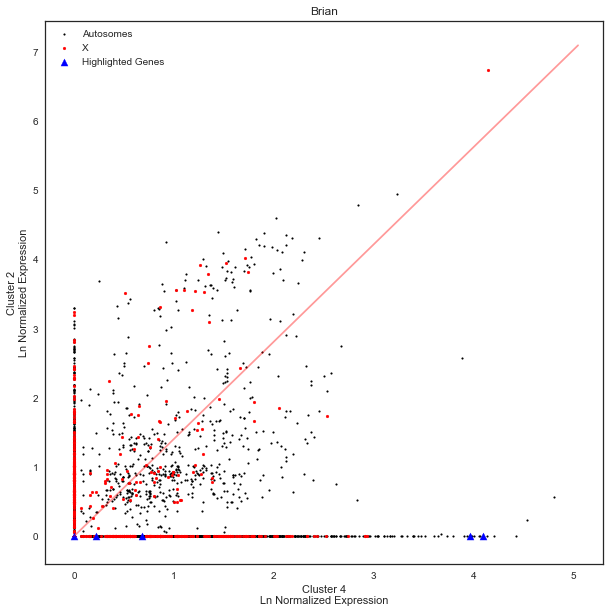

In [60]:
plot_scatter(cluster4, cluster2, 4, 2, BRIAN_FBGN, title='Brian')

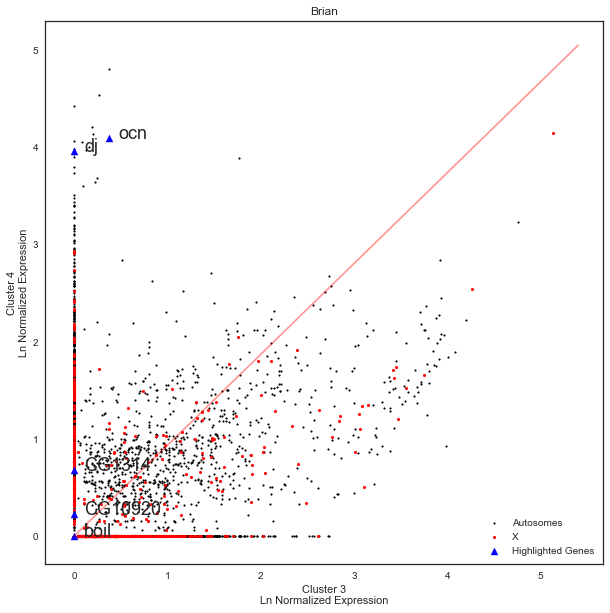

In [61]:
plot_scatter(cluster3, cluster4, 3, 4, BRIAN_FBGN, annotate=True, title='Brian')

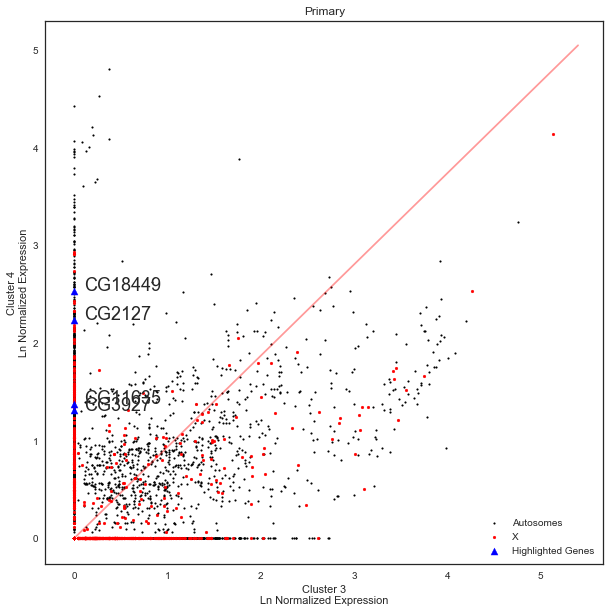

In [64]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_PRIMARY_FBGN, annotate=True, title='Primary')

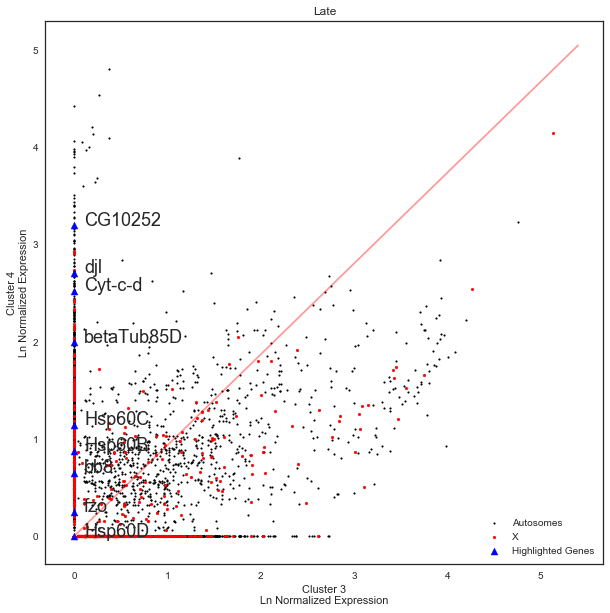

In [65]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_LATE_FBGN, annotate=True, title='Late')

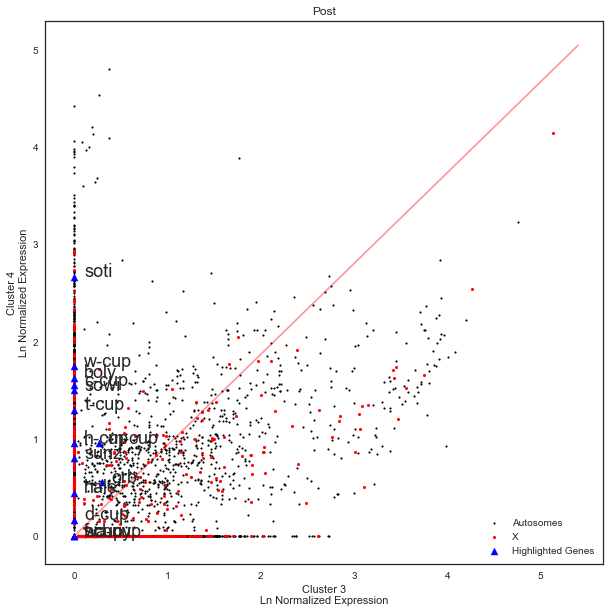

In [66]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_POST_FBGN, annotate=True, title='Post')

['14-3-3epsilon, 14-3-3zeta, ATPsynC, ATPsynD, ATPsynE',
 'ATPsynF, ATPsynO, ATPsynepsilonL, Act5C, Alg-2',
 'Atx2, CCT2, CG10674, CG11138, CG11267',
 'CG11505, CG12384, CG13096, CG13364, CG13540',
 'CG1416, CG14478, CG16817, CG17202, CG17514',
 'CG17650, CG2862, CG31715, CG32971, CG33774',
 'CG34200, CG42857, CG44303, CG44774, CG4502',
 'CG45050, CG5885, CG6770, CG6878, CG6937',
 'CG7518, CG8860, CG9669, CG9705, CG9821',
 'CG9922, CNBP, COX5A, COX6B, COX8',
 'CR43264, Cam, Capr, Cbp20, Cdc37',
 'CtBP, Cyp1, D1, ERp60, FK506-bp1',
 'FKBP59, Fib, Fis1, Fs(2)Ket, Gbeta13F',
 'HP6, His3.3A, His4r, HmgD, Hrb27C',
 'Hrb87F, Hsc70Cb, Hsp26, Hsp27, Hsp83',
 'IscU, Kap-alpha3, Lk6, MED26, MRE16',
 'Mapmodulin, Mnn1, ND-39, ND-ACP, ND-B12',
 'ND-B14.5B, ND-MWFE, Nap1, Nedd8, Nlp',
 'Nop56, Not1, Nph, Pfdn1, Pfdn5',
 'Prosalpha3, Prosalpha5, Prosalpha7, Prosbeta1, Prosbeta4',
 'Prosbeta5, Rad23, Ran, Rho1, RhoGAP71E',
 'Roc1a, RpL10, RpL10Ab, RpL11, RpL12',
 'RpL13, RpL13A, RpL14, RpL15, RpL17',

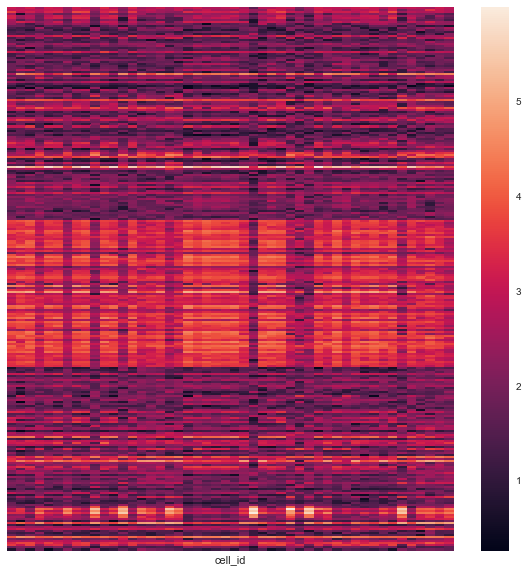

In [17]:
_CLUSTER = 3
clus = mergedNorm[mergedNorm.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, yticklabels=False, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 5)]

['ATPsynCF6L, ATPsynE, ATPsynF, Atg8b, BI-1, CG10252',
 'CG10317, CG10934, CG11106, CG11373, CG11562, CG11663',
 'CG12118, CG12307, CG12470, CG12689, CG12699, CG12853',
 'CG12860, CG12861, CG1324, CG13747, CG13898, CG1394',
 'CG14113, CG1418, CG14488, CG14658, CG14835, CG14995',
 'CG15034, CG15172, CG15177, CG15200, CG15219, CG15461',
 'CG15657, CG15742, CG16739, CG16817, CG17261, CG17376',
 'CG17377, CG17470, CG18449, CG18662, CG1958, CG1988',
 'CG2127, CG2291, CG30039, CG30065, CG30270, CG30324',
 'CG30369, CG30376, CG30430, CG30487, CG31007, CG31050',
 'CG31226, CG3124, CG31360, CG31468, CG31482, CG31639',
 'CG31709, CG31740, CG31788, CG31802, CG31820, CG31909',
 'CG31988, CG32148, CG32192, CG32267, CG32371, CG32450',
 'CG32727, CG33170, CG33189, CG33293, CG33308, CG33340',
 'CG34107, CG34168, CG34241, CG3687, CG42355, CG42393',
 'CG42523, CG42659, CG42688, CG42703, CG42758, CG43059',
 'CG43169, CG43209, CG43222, CG43277, CG43293, CG4375',
 'CG43922, CG43935, CG45490, CG45603, CG460

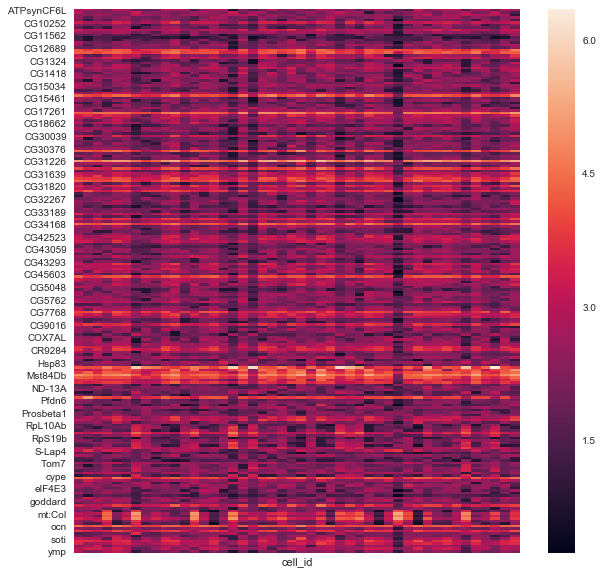

In [18]:
_CLUSTER = 4
clus = mergedNorm[mergedNorm.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 6)]

,gene_symbol,primary_FBgn,secondary_FBgn,annotation_ID,secondary_annotation_ID
0,d,FBgn0262029,"FBgn0032045,FBgn0086896,FBgn0000410,FBgn002597...",CG42840,"CG10595,CG13087,CG31610"
1,CG32532,FBgn0052532,"FBgn0031027,FBgn0031028,FBgn0031029",CG32532,"CG14203,CG14202,CG14201"
2,CG3156,FBgn0023536,NaN,CG3156,NaN
3,mRpL30,FBgn0029718,NaN,CG7038,NaN
4,CG1631,FBgn0031101,NaN,CG1631,NaN
